#Part 1: Linear Regression and Model Complexity

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In this lecture, we will work with the `vehicles` dataset.

In [2]:
vehicles = sns.load_dataset("mpg").rename(columns={"horsepower":"hp"}).dropna().sort_values("hp")
vehicles.head()

,mpg,cylinders,displacement,hp,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


In [3]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 19 to 116
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   hp            392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model_year    392 non-null    int64  
 7   origin        392 non-null    object 
 8   name          392 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 30.6+ KB


We will attempt to predict a car's "mpg" from transformations of its "hp".



In [4]:
X = vehicles[["hp"]]
X["hp^2"] = vehicles["hp"]**2
X["hp^3"] = vehicles["hp"]**3
X["hp^4"] = vehicles["hp"]**4

Y = vehicles["mpg"]

Test Sets

To perform a train-test split, we can use the train_test_split function of the sklearn.model_selection module.

In [5]:
from sklearn.model_selection import train_test_split

# `test_size` specifies the proportion of the full dataset that should be allocated to testing.
# `random_state` makes our results reproducible for educational purposes.
# shuffle is True by default and randomizes the data before splitting.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=100,
                                                    shuffle=True)

print(f"Size of full dataset: {X.shape[0]} points")
print(f"Size of training set: {X_train.shape[0]} points")
print(f"Size of test set: {X_test.shape[0]} points")

Size of full dataset: 392 points
Size of training set: 313 points
Size of test set: 79 points


We then fit the model using the training set...



In [6]:
import sklearn.linear_model as lm

model = lm.LinearRegression()

**Insert a code block below to train the model with the training set.**

In [7]:
model.fit(X_train, Y_train)

LinearRegression()

In [8]:
from sklearn.metrics import mean_squared_error

**Insert a code block below, make predictions on both training set and test set, and print the mean squared error.**

In [10]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(Y_train, Y_train_pred)
test_mse = mean_squared_error(Y_test, Y_test_pred)

print(f"Mean squared error on training set: {train_mse}")
print(f"Mean squared error on test set: {test_mse}")

Mean squared error on training set: 17.124734088083937
Mean squared error on test set: 26.369250398714854


**Insert a txt block below and answer the question: Try to explain why the model performs more poorly on the test data.**

The test data and training data were from the same set, but still had different values. As a result, certain patterns may show up slightly differently between them and a model trained to fit the training data will naturally predict it better than data it has not seen before, even if they came from the same batch.

Validation Sets


To assess model performance on unseen data, then use this information to finetune the model, we introduce a validation set. You can imagine this as us splitting the training set into a validation set and a "mini" training set.



In [11]:
# Split X_train further into X_train_mini and X_val.
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=100)


**Insert a code cell below to print the size of original training set, mini training set, and validation set.**

In [12]:
print(f"Size of original training set: {X_train.shape[0]} points")
print(f"Size of mini training set: {X_train_mini.shape[0]} points")
print(f"Size of validation set: {X_val.shape[0]} points")

Size of original training set: 313 points
Size of mini training set: 250 points
Size of validation set: 63 points


In the cell below, we fit several models of increasing complexity, then compute their errors. Here, we find the model's errors on the validation set to understand how model complexity influences performance on unseen data.

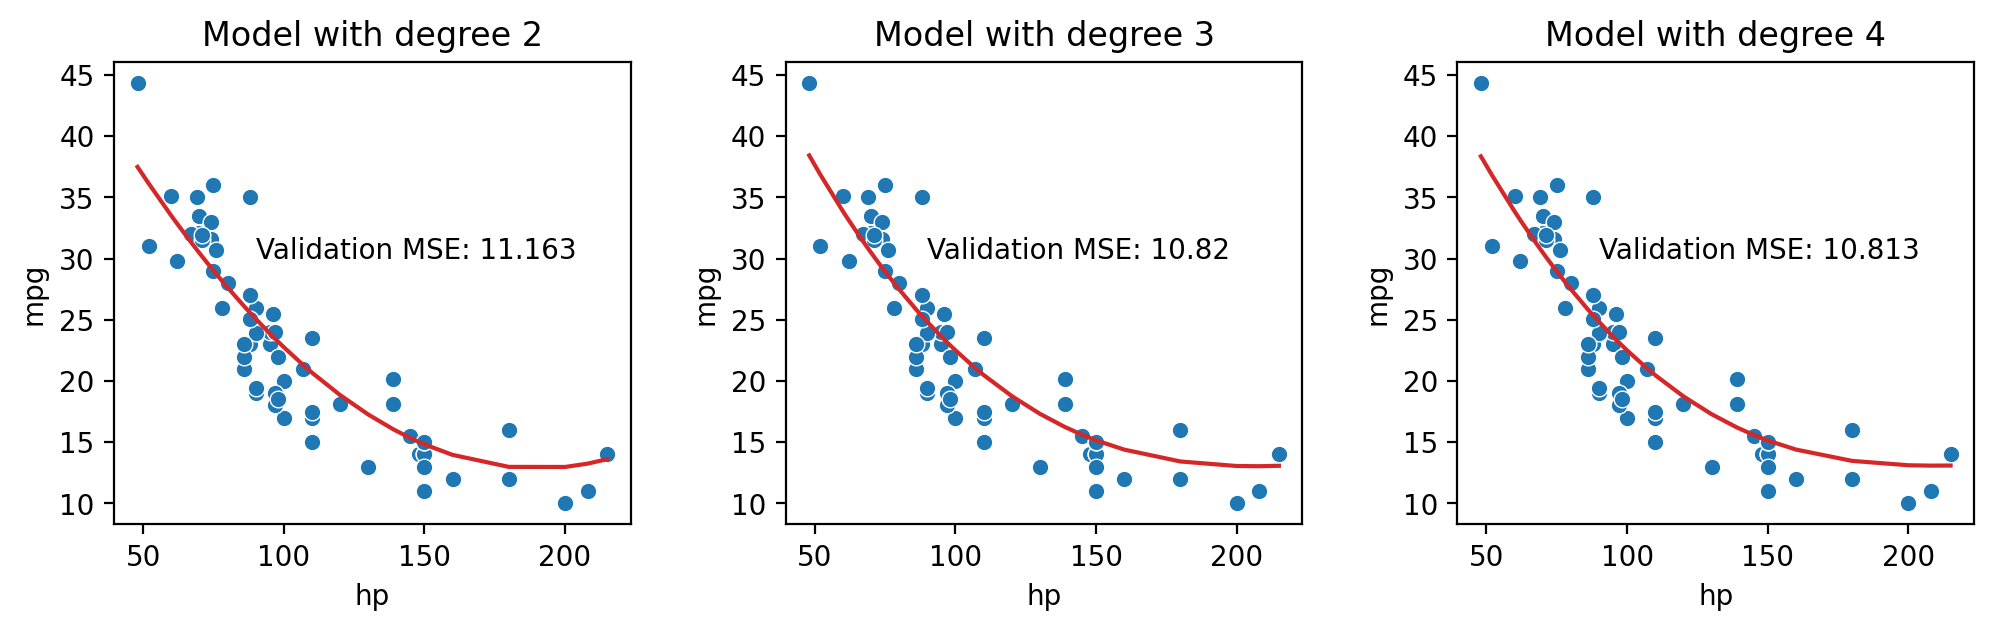

In [13]:
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(12, 3))

for order in [2, 3, 4]:
    model = lm.LinearRegression()
    model.fit(X_train_mini.iloc[:, :order], Y_train_mini)
    val_predictions = model.predict(X_val.iloc[:, :order])

    output = X_val.iloc[:, :order]
    output["y_hat"] = val_predictions
    output = output.sort_values("hp")

    ax[order-2].scatter(X_val["hp"], Y_val, edgecolor="white", lw=0.5)
    ax[order-2].plot(output["hp"], output["y_hat"], "tab:red")
    ax[order-2].set_title(f"Model with degree {order}")
    ax[order-2].set_xlabel("hp")
    ax[order-2].set_ylabel("mpg")
    ax[order-2].annotate(f"Validation MSE: {np.round(mean_squared_error(Y_val, val_predictions), 3)}", (90, 30))

plt.subplots_adjust(wspace=0.3);

Let's repeat this process:

1. Fit an degree-x model to the mini training set
2. Evaluate the fitted model's MSE when making predictions on the validation set.  
We use the model's performance on the validation set as a guide to selecting the best combination of features. We are not limited in the number of times we use the validation set – we just never use this set to fit the model.

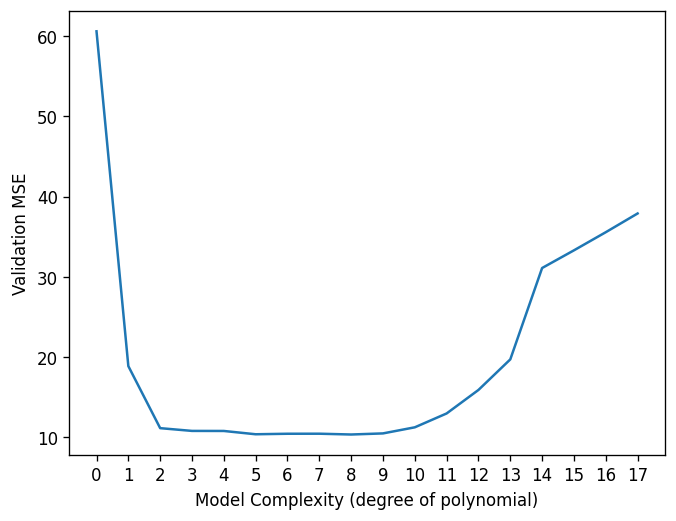

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

def fit_model_dataset(degree):
    pipelined_model = Pipeline([
            ('polynomial_transformation', PolynomialFeatures(degree)),
            ('linear_regression', lm.LinearRegression())
        ])

    pipelined_model.fit(X_train_mini[["hp"]], Y_train_mini)
    return mean_squared_error(Y_val, pipelined_model.predict(X_val[["hp"]]))

errors = [fit_model_dataset(degree) for degree in range(0, 18)]
MSEs_and_k = pd.DataFrame({"k": range(0, 18), "MSE": errors})

plt.figure(dpi=120)
plt.plot(range(0, 18), errors)
plt.xlabel("Model Complexity (degree of polynomial)")
plt.ylabel("Validation MSE")
plt.xticks(range(0, 18));

**Insert a txt block and answer the question: Looking at the figure above, what values of degree of polynomial lead to underfitting and overfitting of the model?**

degrees of less than 2 result in underfitting, while degrees of 10 or more start to result in overfitting.

In [15]:
MSEs_and_k.rename(columns={"k":"Degree"}).set_index("Degree")


,MSE
Degree,
0,60.571088
1,18.886089
2,11.163157
3,10.820312
4,10.813260
5,10.402538
6,10.466447
7,10.471723
8,10.372303


From this model selection process, we might choose to create a model with degree 8.



In [16]:
print(f'Polynomial degree with lowest validation error: {MSEs_and_k.sort_values("MSE").head(1)["k"].values}')


Polynomial degree with lowest validation error: [8]


After this choice has been finalized, and we are completely finished with the model design process, we finally assess model performance on the test set. We typically use the entire training set (both the "mini" training set and validation set) to fit the final model.



In [17]:
# Update our training and test sets to include all polynomial features between 5 and 9
for degree in range(5, 9):
    X_train[f"hp^{degree}"] = X_train["hp"]**degree
    X_test[f"hp^{degree}"] = X_test["hp"]**degree

**Insert code blocks below, train a linear regression model, and show the mean square error on the test set.**

In [18]:
# Train a linear regression model on the full training set
model = lm.LinearRegression()
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_test_pred = model.predict(X_test)

# Calculate and print the mean squared error on the test set
test_mse = mean_squared_error(Y_test, Y_test_pred)
print(f"Mean squared error on test set: {test_mse}")

Mean squared error on test set: 25.623666540743223


#Part 2: Cross-Validation


The validation set gave us an opportunity to understand how the model performs on a single set of unseen data. The specific validation set we drew was fixed – we used the same validation points every time.

It's possible that we may have, by random chance, selected a set of validation points that was not representative of other unseen data that the model might encounter (for example, if we happened to have selected all outlying data points for the validation set).

Different train/validation splits lead to different validation errors:

**Add code in the code block below, create a for-loop with i ranges from 1 to 4, split the training set (X_train, Y_train) into train_mini set and val set with random state equals i, create a linear regression model, train the model, and print the mean square error on val set**.

In [19]:
for i in range(1, 4):
    ### Add your code here ###

    ## Split the training set
    X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=i)

    ## Create a linear regression model
    model = lm.LinearRegression()

    ## Train
    model.fit(X_train_mini, Y_train_mini)

    ## Predict
    y_hat = model.predict(X_val)

    ### End of your code ###
    print(f"Val error from train/validation split #{i}: {mean_squared_error(y_hat, Y_val)}")

Val error from train/validation split #1: 14.837018633166288
Val error from train/validation split #2: 17.044465634655772
Val error from train/validation split #3: 14.413713923694118


To apply cross-validation, we use the KFold class of sklearn.model_selection. KFold will return the indices of each cross-validation fold. Then, we iterate over each of these folds to designate it as the validation set, while training the model on the remaining folds.

In [20]:
from sklearn.model_selection import KFold
np.random.seed(25) # Ensures reproducibility of this notebook

# n_splits sets the number of folds to create
kf = KFold(n_splits=5, shuffle=True)
validation_errors = []

for train_idx, valid_idx in kf.split(X_train):
    # Split the data
    split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
    split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

    # Fit the model on the training split
    model.fit(split_X_train, split_Y_train)

    error = mean_squared_error(model.predict(split_X_valid), split_Y_valid)

    validation_errors.append(error)

print(f"Cross-validation error: {np.mean(validation_errors)}")

Cross-validation error: 17.30376102015582


**Open txt blocks below, and answer the following question:**  
1. How many folds do we split the training set?
2. Based on the number of folds, how many percentages of training set (X_train) are split into split_X_train and split_X_valid? Add code to validate your answer.

1. 5 folds
2. roughly 80% in the training set and 20% in the validation set

In [21]:
print(f"Percentage of training set in split_X_train: {split_X_train.shape[0] / X_train.shape[0] * 100:.2f}%")
print(f"Percentage of training set in split_X_valid: {split_X_valid.shape[0] / X_train.shape[0] * 100:.2f}%")

Percentage of training set in split_X_train: 80.19%
Percentage of training set in split_X_valid: 19.81%


#Part 3: Regularization

L1 (LASSO) Regularization  
To apply L1 regularization, we use the Lasso model class of sklearn. Lasso functions just like LinearRegression. The difference is that now the model will apply a regularization penalty. We specify the strength of regularization using the alpha parameter.

In [22]:
import sklearn.linear_model as lm

lasso_model = lm.Lasso(alpha=0.1) # In sklearn, alpha represents the lambda hyperparameter
lasso_model.fit(X_train, Y_train)

lasso_model.coef_

array([-5.41934735e-01,  1.28427426e-03,  2.87736662e-06, -1.06303866e-09,
       -3.05383047e-11, -1.11200763e-13, -6.39186902e-17,  1.93470616e-18])

To increase the strength of regularization (decrease model complexity), we increase the
λ
 hyperparameter by changing alpha.

**Insert a code block below, create a Lasso model named "lasso_model_large_lambda" with alpha=10, train the model, and print the coefficients.**

In [23]:
lasso_model_large_lambda = lm.Lasso(alpha=10)
lasso_model_large_lambda.fit(X_train, Y_train)
print(lasso_model_large_lambda.coef_)

[-0.00000000e+00 -3.49705844e-03  1.39041552e-05  1.77889603e-08
 -2.68239863e-11 -2.25546292e-13 -5.74002413e-16  7.30262049e-19]


Notice that these model coefficients are very small (some are effectively 0). This reflects L1 regularization's tendency to set the parameters of unimportant features to 0. We can use this in feature selection.

The features in our dataset are on wildly different numerical scales. To see this, compare the values of hp to the values of hp^8.

In [24]:
X_train.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
208,150.0,22500.0,3375000.0,5.062500e+08,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17
41,150.0,22500.0,3375000.0,5.062500e+08,7.593750e+10,1.139062e+13,1.708594e+15,2.562891e+17
92,158.0,24964.0,3944312.0,6.232013e+08,9.846580e+10,1.555760e+13,2.458100e+15,3.883799e+17
212,180.0,32400.0,5832000.0,1.049760e+09,1.889568e+11,3.401222e+13,6.122200e+15,1.101996e+18
88,137.0,18769.0,2571353.0,3.522754e+08,4.826172e+10,6.611856e+12,9.058243e+14,1.240979e+17


In order for the feature hp to contribute in any meaningful way to the model, LASSO is "forced" to allocate disproportionately much of its parameter "budget" towards assigning a large value to the model parameter for hp. Notice how the parameter for hp is much, much greater in magnitude than the parameter for hp^8.



In [25]:
pd.DataFrame({"Feature":X_train.columns, "Parameter":lasso_model.coef_})


,Feature,Parameter
0,hp,-5.419347e-01
1,hp^2,1.284274e-03
2,hp^3,2.877367e-06
3,hp^4,-1.063039e-09
4,hp^5,-3.053830e-11
5,hp^6,-1.112008e-13
6,hp^7,-6.391869e-17
7,hp^8,1.934706e-18


We typically scale data before regularization such that all features are measured on the same numeric scale. One way to do this is by standardizing the data such that it has mean 0 and standard deviation 1.



In [26]:
# Center the data to have mean 0
X_train_centered = X_train - X_train.mean()

# Scale the centered data to have SD 1
X_train_standardized = X_train_centered/X_train_centered.std()

X_train_standardized.head()

,hp,hp^2,hp^3,hp^4,hp^5,hp^6,hp^7,hp^8
208,1.135297,0.984896,0.775312,0.553371,0.354272,0.194283,0.074957,-0.009505
41,1.135297,0.984896,0.775312,0.553371,0.354272,0.194283,0.074957,-0.009505
92,1.339125,1.231354,1.041813,0.815907,0.594634,0.402529,0.248159,0.130244
212,1.899651,1.975127,1.925462,1.773459,1.560109,1.324804,1.094889,0.885230
88,0.804077,0.611709,0.399115,0.207724,0.058991,-0.044537,-0.110553,-0.149359


When we re-fit a LASSO model, the coefficients are no longer as uneven in magnitude as they were before.



**Insert a code cell below, create a Lasso model with alpha=0.1, train the model on the standardized set, and print the coefficient.**

In [27]:
lasso_model_standardized = lm.Lasso(alpha=0.1)
lasso_model_standardized.fit(X_train_standardized, Y_train)
print(lasso_model_standardized.coef_)

[-9.57111161  0.          0.          3.82041744  0.          0.
  0.          0.        ]


L2 (Ridge) Regression


We perform ridge regression using sklearn's Ridge class.

In [28]:
ridge_model = lm.Ridge(alpha=0.1)
ridge_model.fit(X_train_standardized, Y_train)

ridge_model.coef_

array([-17.71921882,   3.82482591,   9.83246396,   4.75340388,
        -2.61166058,  -6.0632227 ,  -3.38200322,   5.07149977])

**Insert a code cell below, print the mean squared error of the ridge model on the training set.**

In [29]:
ridge_train_pred = ridge_model.predict(X_train_standardized)
ridge_train_mse = mean_squared_error(Y_train, ridge_train_pred)
print(f"Mean squared error on training set (Ridge): {ridge_train_mse}")

Mean squared error on training set (Ridge): 17.096597186624706


#Part 4: Using cross-validation to optimize regularization parameters

**Add code in the code cell below, using cross-validation to find the best regularization parameter `alpha`**:


In [30]:
from sklearn.model_selection import KFold
np.random.seed(25) # Ensures reproducibility of this notebook

# n_splits sets the number of folds to create
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for alpha in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    validation_errors = []

    ## Add your code here: create a Ridge model, with alpha=alpha
    model = lm.Ridge(alpha=alpha)

    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]


        # Add your code here, fit the model on the training split
        model.fit(split_X_train, split_Y_train)

        # Add your code here, calculate the mean square error on the validation set
        error = mean_squared_error(model.predict(split_X_valid), split_Y_valid)

        validation_errors.append(error)

    print(f"Cross-validation error for alpha = {alpha}: {np.mean(validation_errors)}")

Cross-validation error for alpha = 0.001: 17.4420629134297
Cross-validation error for alpha = 0.01: 17.293758468282782
Cross-validation error for alpha = 0.1: 17.231047502259095
Cross-validation error for alpha = 1: 17.22373953137951
Cross-validation error for alpha = 10: 17.222566001456396
Cross-validation error for alpha = 100: 17.218775186777076
Cross-validation error for alpha = 1000: 17.223248000753976


Make sure all cells are visible and have been run (rerun if necessary).

The code below converts the ipynb file to PDF, and saves it to where this .ipynb file is.

In [ ]:
NOTEBOOK_PATH = # Enter here, the path to your notebook file, e.g. "/content/drive/MyDrive/ECEN250/ECEN250_Lab6.ipynb". Do not change the lines below, and make sure you do not have multiple notebooks with the same path.
! pip install playwright
! jupyter nbconvert --to webpdf --allow-chromium-download "$NOTEBOOK_PATH"

Download your notebook as an .ipynb file, then upload it along with the PDF file (saved in the same Google Drive folder as this notebook) to Canvas for Lab 4. Make sure that the PDF file matches your .ipynb file.